In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import datetime
import os
import xml.etree.ElementTree as ET

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error

## Top

In [2]:
if torch.cuda.is_available():
    print("CUDA is available! Training on GPU...")
else:
    print("CUDA is not available. Training on CPU...")

CUDA is available! Training on GPU...


In [ ]:
# Define the directory path
train_directory_path = r'C:\Users\username\OneDrive\Desktop\BGprediction\DiaTrend\train'  # Use a raw string for paths on Windows

# List files without their extensions
train_file_names = [os.path.splitext(file)[0] for file in os.listdir(train_directory_path)
              if os.path.isfile(os.path.join(train_directory_path, file))]

# Print the list of file names
print(train_file_names)

In [3]:
subject = pd.read_csv(f"../DiaTrend/train/Subject1_training_data.csv")

In [4]:
subject.head(10)

,date,mg/dl
0,2015-12-01 21:01:07.925,160
1,2015-12-01 21:06:07.043,161
2,2015-12-01 21:11:08.277,165
3,2015-12-01 21:16:08.223,162
4,2015-12-01 21:21:07.953,163
5,2015-12-01 21:26:07.943,166
6,2015-12-01 21:31:13.902,167
7,2015-12-01 21:36:06.755,164
8,2015-12-01 21:41:09.283,162
9,2015-12-01 21:46:07.121,150


In [3]:
def preprocess_DiaTrend(path):

    subject = pd.read_csv(path)
    subject['date'] = pd.to_datetime(subject['date'], errors='coerce')  # Convert 'date' column to datetime if not already
    # print(subject['date'][0])
    subject.sort_values('date', inplace=True)  # Sort the DataFrame by the 'date' column

    # Assuming self.interval_timedelta is set, for example:
    interval_timedelta = datetime.timedelta(minutes=6)  # Example timedelta of 6 minutes, providing a range for latency

    # Create a list to store the results
    res = []

    # Initialize the first group
    if not subject.empty:
        current_group = [subject.iloc[0]['mg/dl']]
        last_time = subject.iloc[0]['date']

    # Iterate over rows in DataFrame starting from the second row
    for index, row in subject.iloc[1:].iterrows():
        current_time = row['date']
        if (current_time - last_time) <= interval_timedelta:
            # If the time difference is within the limit, add to the current group
            current_group.append(row['mg/dl'])
        else:
            # Otherwise, start a new group
            res.append(current_group)
            current_group = [row['mg/dl']]
        last_time = current_time

    # Add the last group if it's not empty
    if current_group:
        res.append(current_group)
    
    # Filter out groups with fewer than 10 glucose readings
    res = [group for group in res if len(group) >= 10]

    return res

In [4]:
def preprocess_OhioT1DM(path):
    tree = ET.parse(path)
    root = tree.getroot()
    interval_timedelta = datetime.timedelta(minutes=6)

    res = []
    for item in root.findall("glucose_level"):
        entry0 = item[0].attrib
        res.append([float(entry0["value"])])
        for i in range(1, len(item)):
            last_entry = item[i - 1].attrib
            entry = item[i].attrib
            t1 = datetime.datetime.strptime(entry["ts"], "%d-%m-%Y %H:%M:%S")
            t0 = datetime.datetime.strptime(last_entry["ts"], "%d-%m-%Y %H:%M:%S")
            delt = t1 - t0
            if delt <= interval_timedelta:
                res[-1].append(float(entry["value"]))
            else:
                res.append([float(entry["value"])])
    return res



In [ ]:
res = preprocess_DiaTrend(f"../DiaTrend/train/Subject2_training_data.csv")

In [5]:
res = preprocess_OhioT1DM(f"../OhioT1DM/2018/train/559-ws-training.xml")

In [ ]:
def create_sequences(data, seq_length, pred_step):
    """
    Create sequences and targets from time series data.

    Args:
    data (list or ndarray): The time series data.
    seq_length (int): Length of the sequence.
    pred_step (int): Steps ahead to predict.

    Returns:
    tuple of torch.Tensors: sequences and targets.
    """
    sequences = []
    targets = []
    for i in range(len(data) - seq_length - pred_step + 1):
        sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length+pred_step-1])
    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)


reconstruct_data = create_sequences(res[0], 6, 3)
reconstruct_data

In [ ]:
reconstruct_data[1]

In [8]:
# Loop thru all subjects to stack the data
X_stack_tensor = []
y_stack_tensor = []

for ii in res:
    reconstruct_data = create_sequences(ii, 6, 3) # sequence length = 6(30min), pediction_horizon = 3(predict 15 minutes ahead)
    
    X_stack_tensor.append(reconstruct_data[0])
    y_stack_tensor.append(reconstruct_data[1])

In [9]:
len(X_stack_tensor)

43

In [10]:
all_sequences = torch.cat(X_stack_tensor, dim=0) # yy_0 includes the X
all_targets = torch.cat(y_stack_tensor, dim=0) # yy_1 includes the y label

print(len(all_sequences))
print(len(all_targets))

10452
10452


In [11]:
# Convert to numpy for train_test_split if needed
from sklearn.model_selection import train_test_split
sequences_train, sequences_val, targets_train, targets_val = train_test_split(
    all_sequences, all_targets, test_size=0.2, shuffle=False
)

# # Convert numpy arrays back to torch tensors
# sequences_train = torch.from_numpy(sequences_train)
# sequences_val = torch.from_numpy(sequences_val)
# targets_train = torch.from_numpy(targets_train)

# targets_val = torch.from_numpy(targets_val)
    

In [12]:
sequences_train.shape

torch.Size([8361, 6])

In [13]:
targets_train.shape

torch.Size([8361])

In [14]:
sequences_val.shape

torch.Size([2091, 6])

## RNN

In [ ]:
# Create TensorDataset and DataLoader
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(sequences_train, targets_train)
val_dataset = TensorDataset(sequences_val, targets_val)
train_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_data_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True, nonlinearity='relu')
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.rnn(x)
        # print("Shape after RNN:", out.shape)  # Debugging: Check shape after RNN
        # out = out[:, -1, :]
        # print("Shape before FC:", out.shape)  # Debugging: Check shape before FC
        out = self.fc(out)
        return out


In [17]:
# Model parameters
input_size = sequences_train.shape[-1]  # Number of features
hidden_size = 50
output_size = 1

# Model instantiation
model_rnn = RNNModel(input_size, hidden_size, output_size)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_rnn.parameters())


In [ ]:
# Assuming x_train_uni and y_train_uni are torch tensors and properly formatted
# Training and validation loop
def train_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0
    for data, target in loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def validate_epoch(model, loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
    return total_loss / len(loader)

# Run training and validation

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model_rnn.to(device)
num_epochs = 100
for epoch in range(num_epochs):
    train_loss = train_epoch(model_rnn, train_data_loader, optimizer)
    val_loss = validate_epoch(model_rnn, val_data_loader)
    print(f'Epoch {epoch+1}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}')


In [19]:
import torch
import matplotlib.pyplot as plt

def get_predictions_and_targets(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Ensure model is on the right device
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)  # Move data & target to the same device as model
            output = model(data)
            predictions.extend(output.detach().cpu().numpy())  # Move output back to CPU for storage/manipulation
            targets.extend(target.detach().cpu().numpy())
    return predictions, targets

# Assuming model and val_loader are already defined
predictions, targets = get_predictions_and_targets(model_rnn, val_data_loader)



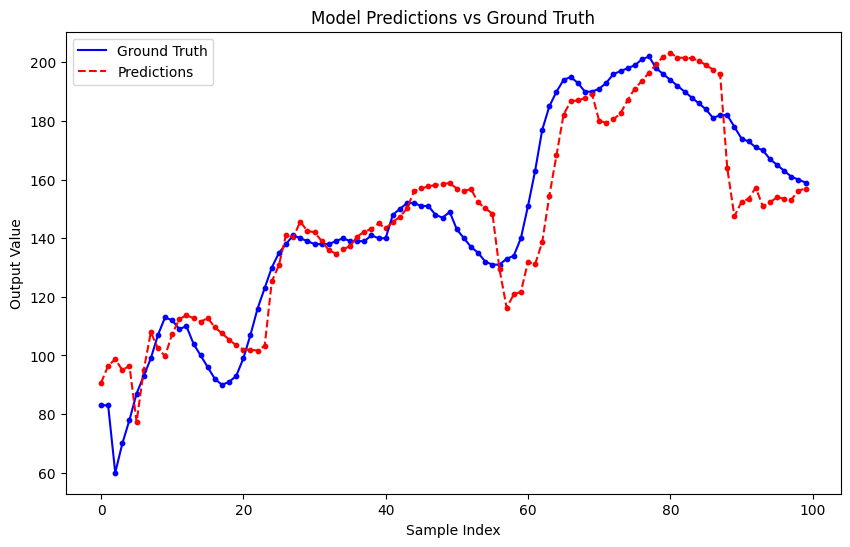

In [20]:
import matplotlib.pyplot as plt

def plot_predictions_vs_targets(predictions, targets):
    plt.figure(figsize=(10, 6))
    plt.plot(targets, label='Ground Truth', color='blue')
    plt.plot(predictions, label='Predictions', color='red', linestyle='--')
    plt.scatter(range(len(targets)), targets, color='blue', s=10)  # Ground truth points
    plt.scatter(range(len(predictions)), predictions, color='red', s=10)  # Prediction points
    plt.title('Model Predictions vs Ground Truth')
    plt.xlabel('Sample Index')
    plt.ylabel('Output Value')
    plt.legend()
    plt.show()

plot_predictions_vs_targets(predictions[200:300], targets[200:300])


In [21]:
import torch
from sklearn.metrics import mean_squared_error

def rmse_pytorch(predictions, targets):
    # Convert predictions and targets to float tensors if they are not already
    predictions = predictions.float()
    targets = targets.float()
    
    # Calculate MSE
    # mse = torch.mean((predictions - targets) ** 2)
    mse = mean_squared_error(targets, predictions)
    
    # Calculate RMSE
    rmse = np.sqrt(mse)
    return rmse

# Example usage:
# predictions, targets should be PyTorch tensors
# Assuming predictions and targets are already defined:
rmse_value = rmse_pytorch(torch.tensor(predictions), torch.tensor(targets))
print(f'RMSE: {rmse_value.item()}')


RMSE: 33.85307693481445


C:\Users\username\AppData\Local\Temp\ipykernel_28444\1082537536.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  rmse_value = rmse_pytorch(torch.tensor(predictions), torch.tensor(targets))


Text(0.5, 1.0, 'Simple RNN Normal Q-Q Plot')

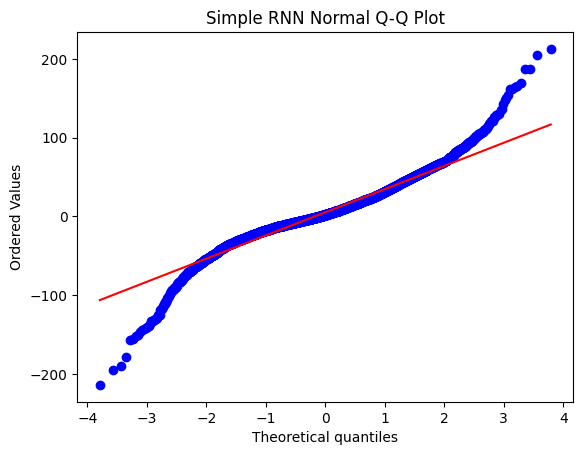

In [24]:
from scipy.stats import probplot

residuals = [targets[i]-predictions[i] for i in range(len(predictions))]
converted_list = [float(arr.item()) for arr in predictions]
residuals = np.array(targets) - np.array(converted_list)
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Normal Q-Q Plot")

In [25]:
from sklearn.metrics import mean_squared_error
def RMSE(y_test,y_predict):
    return np.sqrt(mean_squared_error(y_test,y_predict))

RMSE(targets, predictions)

30.640112

## For all subjects

In [3]:
sequence_window = 12 # *5
prediction_horizon = 6 # *5 minute ahead
hidden_size = 256
output_size = 1
num_epochs = 100

In [4]:
def preprocess_DiaTrend(path):

    subject = pd.read_csv(path)
    subject['date'] = pd.to_datetime(subject['date'], errors='coerce')  # Convert 'date' column to datetime if not already
    # print(subject['date'][0])
    subject.sort_values('date', inplace=True)  # Sort the DataFrame by the 'date' column

    # Assuming self.interval_timedelta is set, for example:
    interval_timedelta = datetime.timedelta(minutes=6)  # Example timedelta of 6 minutes, providing a range for latency

    # Create a list to store the results
    res = []

    # Initialize the first group
    if not subject.empty:
        current_group = [subject.iloc[0]['mg/dl']]
        last_time = subject.iloc[0]['date']

    # Iterate over rows in DataFrame starting from the second row
    for index, row in subject.iloc[1:].iterrows():
        current_time = row['date']
        if (current_time - last_time) <= interval_timedelta:
            # If the time difference is within the limit, add to the current group
            current_group.append(row['mg/dl'])
        else:
            # Otherwise, start a new group
            res.append(current_group)
            current_group = [row['mg/dl']]
        last_time = current_time

    # Add the last group if it's not empty
    if current_group:
        res.append(current_group)
    
    # Filter out groups with fewer than 10 glucose readings
    res = [group for group in res if len(group) >= 10]

    return res

In [5]:
def preprocess_OhioT1DM(path):
    tree = ET.parse(path)
    root = tree.getroot()
    interval_timedelta = datetime.timedelta(minutes=6)

    res = []
    for item in root.findall("glucose_level"):
        entry0 = item[0].attrib
        res.append([float(entry0["value"])])
        for i in range(1, len(item)):
            last_entry = item[i - 1].attrib
            entry = item[i].attrib
            t1 = datetime.datetime.strptime(entry["ts"], "%d-%m-%Y %H:%M:%S")
            t0 = datetime.datetime.strptime(last_entry["ts"], "%d-%m-%Y %H:%M:%S")
            delt = t1 - t0
            if delt <= interval_timedelta:
                res[-1].append(float(entry["value"]))
            else:
                res.append([float(entry["value"])])
    return res


In [6]:
def create_sequences(data, seq_length, pred_step):
    """
    Create sequences and targets from time series data.

    Args:
    data (list or ndarray): The time series data.
    seq_length (int): Length of the sequence.
    pred_step (int): Steps ahead to predict.

    Returns:
    tuple of torch.Tensors: sequences and targets.
    """
    sequences = []
    targets = []
    for i in range(len(data) - seq_length - pred_step + 1):
        sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length+pred_step-1])
    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

In [7]:
# FOR DIATREND

# Define the directory path
train_directory_path = r'C:\Users\username\OneDrive\Desktop\BGprediction\DiaTrend\train'  # Use a raw string for paths on Windows

# List files without their extensions
train_file_names = [os.path.splitext(file)[0] for file in os.listdir(train_directory_path)
              if os.path.isfile(os.path.join(train_directory_path, file))]

# Print the list of file names
print(train_file_names)

['Subject11_training_data', 'Subject15_training_data', 'Subject26_training_data', 'Subject30_training_data', 'Subject31_training_data', 'Subject36_training_data', 'Subject37_training_data', 'Subject38_training_data', 'Subject39_training_data', 'Subject3_training_data', 'Subject41_training_data', 'Subject42_training_data', 'Subject43_training_data', 'Subject5_training_data', 'Subject6_training_data', 'Subject8_training_data']


In [11]:
# FOR OHIOT1DM

train_directory_path = r'C:\Users\username\OneDrive\Desktop\BGprediction\OhioT1DM\2018\train'  # Use a raw string for paths on Windows

# List files without their extensions
train_file_names = [os.path.splitext(file)[0] for file in os.listdir(train_directory_path)
              if os.path.isfile(os.path.join(train_directory_path, file))]

# Print the list of file names
print(train_file_names)

['559-ws-training', '563-ws-training', '570-ws-training', '575-ws-training', '588-ws-training', '591-ws-training']


In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True, nonlinearity='relu')
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.rnn(x)
        # print("Shape after RNN:", out.shape)  # Debugging: Check shape after RNN
        # out = out[:, -1, :]
        # print("Shape before FC:", out.shape)  # Debugging: Check shape before FC
        out = self.fc(out)
        return out

In [14]:
class LSTMModel(nn.Module):
    def __init__(self, input_features, hidden_dim, output_features):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_features, hidden_dim, batch_first=True)
        self.relu = nn.ReLU()  # Define ReLU activation
        self.fc = nn.Linear(hidden_dim, output_features)
    
    def forward(self, x):
        # Forward pass through LSTM layer
        lstm_out, _ = self.lstm(x)
        # Apply ReLU activation to the output of the LSTM
        lstm_out = self.relu(lstm_out)  # Applying ReLU to only the last time step's output
        # Pass the output through the fully connected layer
        y_pred = self.fc(lstm_out)
        return y_pred

In [14]:
# def train_epoch(model, loader, optimizer):
#     model.train()
#     total_loss = 0
#     for data, target in loader:
#         optimizer.zero_grad()
        
#         output = model(data)
#         loss = criterion(output, target)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
#     return total_loss / len(loader)

# def validate_epoch(model, loader):
#     model.eval()
#     total_loss = 0
#     with torch.no_grad():
#         for data, target in loader:
#             output = model(data)
#             loss = criterion(output, target)
#             total_loss += loss.item()
#     return total_loss / len(loader)

In [9]:
def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    for data, target in loader:
        data, target = data.to(device), target.to(device)  # Move data to the correct device
        optimizer.zero_grad()
        
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def validate_epoch(model, loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)  # Move data to the correct device
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
    return total_loss / len(loader)





In [10]:
def get_predictions_and_targets(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Ensure model is on the right device
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)  # Move data & target to the same device as model
            output = model(data)
            predictions.extend(output.detach().cpu().numpy())  # Move output back to CPU for storage/manipulation
            targets.extend(target.detach().cpu().numpy())
    return predictions, targets


In [11]:
from sklearn.metrics import mean_squared_error

def rmse_pytorch(predictions, targets):
    # Convert predictions and targets to float tensors if they are not already
    predictions = predictions.float()
    targets = targets.float()
    
    # Calculate MSE
    # mse = torch.mean((predictions - targets) ** 2)
    mse = mean_squared_error(targets, predictions)
    
    # Calculate RMSE
    rmse = np.sqrt(mse)
    return rmse



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device.")
rmse_list = []

for subj in train_file_names:
    res = preprocess_DiaTrend(f"../DiaTrend/train/{subj}.csv") # for Diatrend, it's csv, for 
    # res = preprocess_OhioT1DM(f"../OhioT1DM/2018/train/{subj}.xml")
    # reconstruct_data = create_sequences(res[0], sequence_window, prediction_horizon)
    # Loop thru all subjects to stack the data
    X_stack_tensor = []
    y_stack_tensor = []

    for ii in res:
        reconstruct_data = create_sequences(ii, sequence_window, prediction_horizon) # sequence length = 6(30min), pediction_horizon = 3(predict 15 minutes ahead)
        X_stack_tensor.append(reconstruct_data[0])
        y_stack_tensor.append(reconstruct_data[1])
    
    all_sequences = torch.cat(X_stack_tensor, dim=0) # yy_0 includes the X
    all_targets = torch.cat(y_stack_tensor, dim=0) # yy_1 includes the y label
    sequences_train, sequences_val, targets_train, targets_val = train_test_split(
        all_sequences, all_targets, test_size=0.2, shuffle=False
    )

    # Build the data loader and model
    train_dataset = TensorDataset(sequences_train, targets_train)
    val_dataset = TensorDataset(sequences_val, targets_val)
    train_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    val_data_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Model parameters
    input_size = sequences_train.shape[-1]  # Number of features

    # Model instantiation
    model_rnn = RNNModel(input_size, hidden_size, output_size).to(device)

    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model_rnn.parameters())

    # Training
    for epoch in range(num_epochs):
        train_loss = train_epoch(model_rnn, train_data_loader, optimizer, device)
        val_loss = validate_epoch(model_rnn, val_data_loader, device)
        # Print every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}')

    # Assuming model and val_loader are already defined
    predictions, targets = get_predictions_and_targets(model_rnn, val_data_loader)
    rmse_value = rmse_pytorch(torch.tensor(predictions), torch.tensor(targets))
    rmse_list.append(rmse_value)
    print(f'RMSE: {rmse_value.item()}')
    print(f"=================================================")


In [15]:
rmse_list

[43.213413,
 28.957304,
 31.91793,
 25.906792,
 26.443092,
 33.935417,
 30.781582,
 27.132692,
 21.898863,
 32.458874,
 26.585081,
 27.470108,
 38.945244,
 28.268785,
 28.703484,
 41.456165]

In [ ]:
# Based on LSTM 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device.")
lstm_rmse_list = []

for subj in train_file_names[:10]:
    # res = preprocess_DiaTrend(f"../DiaTrend/train/{subj}.csv")
    res = preprocess_OhioT1DM(f"../OhioT1DM/2018/train/{subj}.xml")
    # reconstruct_data = create_sequences(res[0], sequence_window, prediction_horizon)
    # Loop thru all subjects to stack the data
    X_stack_tensor = []
    y_stack_tensor = []

    for ii in res:
        reconstruct_data = create_sequences(ii, sequence_window, prediction_horizon) # sequence length = 6(30min), pediction_horizon = 3(predict 15 minutes ahead)
        X_stack_tensor.append(reconstruct_data[0])
        y_stack_tensor.append(reconstruct_data[1])
    
    all_sequences = torch.cat(X_stack_tensor, dim=0) # yy_0 includes the X
    all_targets = torch.cat(y_stack_tensor, dim=0) # yy_1 includes the y label
    sequences_train, sequences_val, targets_train, targets_val = train_test_split(
        all_sequences, all_targets, test_size=0.2, shuffle=False
    )

    # Build the data loader and model
    train_dataset = TensorDataset(sequences_train, targets_train)
    val_dataset = TensorDataset(sequences_val, targets_val)
    train_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    val_data_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Model parameters
    input_size = sequences_train.shape[-1]  # Number of features

    # Model instantiation
    model_lstm = LSTMModel(input_size, hidden_size, output_size).to(device)

    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model_lstm.parameters())

    # Training
    for epoch in range(num_epochs):
        train_loss = train_epoch(model_lstm, train_data_loader, optimizer, device)
        val_loss = validate_epoch(model_lstm, val_data_loader, device)
        # Print every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}')

    # Assuming model and val_loader are already defined
    predictions, targets = get_predictions_and_targets(model_lstm, val_data_loader)
    rmse_value = rmse_pytorch(torch.tensor(predictions), torch.tensor(targets))
    lstm_rmse_list.append(rmse_value)
    print(f'RMSE: {rmse_value.item()}')
    print(f"=================================================")


In [44]:
np.average(lstm_rmse_list)

45.173035

## LSTM

In [19]:

class LSTMModel(nn.Module):
    def __init__(self, input_features, hidden_dim, output_features):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_features, hidden_dim, batch_first=True)
        self.relu = nn.ReLU()  # Define ReLU activation
        self.fc = nn.Linear(hidden_dim, output_features)
    
    def forward(self, x):
        # Forward pass through LSTM layer
        lstm_out, _ = self.lstm(x)
        # Apply ReLU activation to the output of the LSTM
        lstm_out = self.relu(lstm_out)  # Applying ReLU to only the last time step's output
        # Pass the output through the fully connected layer
        y_pred = self.fc(lstm_out)
        return y_pred



In [20]:
# Model parameters
input_size = sequences_train.shape[-1]  # Number of features
hidden_size = 50
output_size = 1

# Model instantiation
model_lstm = LSTMModel(input_size, hidden_size, output_size)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_lstm.parameters())

In [ ]:
# Assuming x_train_uni and y_train_uni are torch tensors and properly formatted
# Training and validation loop
def train_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0
    for data, target in loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def validate_epoch(model, loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
    return total_loss / len(loader)

# Run training and validation

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model_rnn.to(device)
num_epochs = 300
for epoch in range(num_epochs):
    train_loss = train_epoch(model_lstm, train_data_loader, optimizer)
    val_loss = validate_epoch(model_lstm, val_data_loader)
    print(f'Epoch {epoch+1}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}')


In [139]:
import torch
import matplotlib.pyplot as plt

def get_predictions_and_targets(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Ensure model is on the right device
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)  # Move data & target to the same device as model
            output = model(data)
            predictions.extend(output.detach().cpu().numpy())  # Move output back to CPU for storage/manipulation
            targets.extend(target.detach().cpu().numpy())
    return predictions, targets

# Assuming model and val_loader are already defined
predictions, targets = get_predictions_and_targets(model_lstm, val_data_loader)



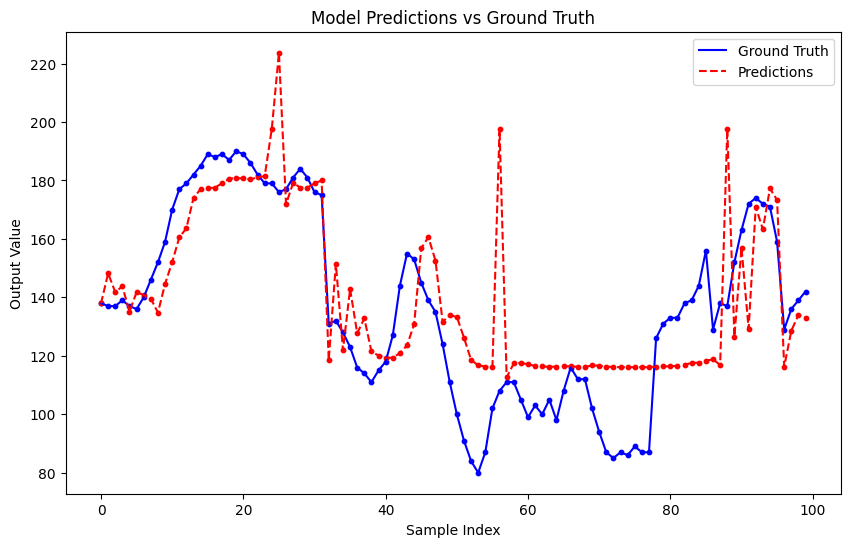

In [140]:
import matplotlib.pyplot as plt

def plot_predictions_vs_targets(predictions, targets):
    plt.figure(figsize=(10, 6))
    plt.plot(targets, label='Ground Truth', color='blue')
    plt.plot(predictions, label='Predictions', color='red', linestyle='--')
    plt.scatter(range(len(targets)), targets, color='blue', s=10)  # Ground truth points
    plt.scatter(range(len(predictions)), predictions, color='red', s=10)  # Prediction points
    plt.title('Model Predictions vs Ground Truth')
    plt.xlabel('Sample Index')
    plt.ylabel('Output Value')
    plt.legend()
    plt.show()

plot_predictions_vs_targets(predictions[200:300], targets[200:300])

In [141]:
def rmse_pytorch(predictions, targets):
    # Convert predictions and targets to float tensors if they are not already
    predictions = predictions.float()
    targets = targets.float()
    
    # Calculate MSE
    mse = torch.mean((predictions - targets) ** 2)
    
    # Calculate RMSE
    rmse = torch.sqrt(mse)
    return rmse

# Example usage:
# predictions, targets should be PyTorch tensors
# Assuming predictions and targets are already defined:
rmse_value = rmse_pytorch(torch.tensor(predictions), torch.tensor(targets))
print(f'RMSE: {rmse_value.item()}')

RMSE: 67.39815521240234


In [ ]:
from sklearn.metrics import mean_squared_error
def RMSE(y_test,y_predict):
    return np.sqrt(mean_squared_error(y_test,y_predict))

RMSE(targets, predictions)

In [ ]:
from scipy.stats import probplot

residuals = [targets[i]-predictions[i] for i in range(len(predictions))]
converted_list = [float(arr.item()) for arr in predictions]
residuals = np.array(targets) - np.array(converted_list)
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Normal Q-Q Plot")

# LSTM for all subjects

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device.")
rmse_list = []

for subj in train_file_names:
    # res = preprocess_DiaTrend(f"../DiaTrend/train/{subj}.csv") # for Diatrend, it's csv, for 
    res = preprocess_OhioT1DM(f"../OhioT1DM/2018/train/{subj}.xml")
    # reconstruct_data = create_sequences(res[0], sequence_window, prediction_horizon)
    # Loop thru all subjects to stack the data
    X_stack_tensor = []
    y_stack_tensor = []

    for ii in res:
        reconstruct_data = create_sequences(ii, sequence_window, prediction_horizon) # sequence length = 6(30min), pediction_horizon = 3(predict 15 minutes ahead)
        X_stack_tensor.append(reconstruct_data[0])
        y_stack_tensor.append(reconstruct_data[1])
    
    all_sequences = torch.cat(X_stack_tensor, dim=0) # yy_0 includes the X
    all_targets = torch.cat(y_stack_tensor, dim=0) # yy_1 includes the y label
    sequences_train, sequences_val, targets_train, targets_val = train_test_split(
        all_sequences, all_targets, test_size=0.2, shuffle=False
    )

    # Build the data loader and model
    train_dataset = TensorDataset(sequences_train, targets_train)
    val_dataset = TensorDataset(sequences_val, targets_val)
    train_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    val_data_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Model parameters
    input_size = sequences_train.shape[-1]  # Number of features

    # Model instantiation
    model_lstm = LSTMModel(input_size, hidden_size, output_size).to(device)

    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model_lstm.parameters())

    # Training
    for epoch in range(num_epochs):
        train_loss = train_epoch(model_lstm, train_data_loader, optimizer, device)
        val_loss = validate_epoch(model_lstm, val_data_loader, device)
        # Print every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}')

    # Assuming model and val_loader are already defined
    predictions, targets = get_predictions_and_targets(model_lstm, val_data_loader)
    rmse_value = rmse_pytorch(torch.tensor(predictions), torch.tensor(targets))
    rmse_list.append(rmse_value)
    print(f'RMSE: {rmse_value.item()}')
    print(f"=================================================")
